# Import the modules 

In [1]:
# import the general modules
from optlang.symbolics import Zero
from itertools import combinations
from matplotlib import pyplot
from numpy import unique
import networkx
import cobra
import cplex
import sys
import re

# import kbase

os.environ["HOME"] = 'C:\\Users\\Andrew Freiburger\\Dropbox\\My PC (DESKTOP-M302P50)\\Documents\\UVic Civil Engineering\\Internships\\Agronne\\cobrakbase'
import cobrakbase
token = 'I6WL7MAW5Z4QO3OQ62YUR6HJM6RAUFHE'
kbase = cobrakbase.KBaseAPI(token)

# import modelseedpy packages
from modelseedpy import KBaseMediaPkg
from modelseedpy.fbapkg import fullthermopkg, elementuptakepkg


cobrakbase 0.2.8


# Define the CommunityFBA function

In [26]:
def communityFBA(modelInfo,mediaInfo,kinetic_coeff,abundances=None):
    # import the model and media
    model = kbase.get_from_ws(modelInfo[0],modelInfo[1])
    media = kbase.get_from_ws(mediaInfo[0],mediaInfo[1])
    kmp = KBaseMediaPkg(model)
    kmp.build_package(media)
    model.solver = 'optlang-cplex'
    
    # applying uptake limit to total carbon uptake by model
    '''eup = elementuptakepkg.ElementUptakePkg(model)
    eup.build_package({"C":60})
    '''
    
    # applying community model kinetic constraints
    '''ckp = CommKineticPkg(model)
    ckp.build_package(kinetic_coeff,abundances)
    '''

    # unambiguously define the model objective 
    biomass_objective = model.problem.Objective(
        1 * model.reactions.bio1.flux_expression,
        direction='max')
    model.objective = biomass_objective

    # excute FBA
    solution = model.optimize()
    display(model.summary())
    '''pfba_solution = cobra.flux_analysis.pfba(model)'''
    
    # calculate the metabolic exchanges
    metabolite_uptake = {}
    compartment_numbers = []
    for rxn in model.reactions:
        if (rxn.id[-2] == 'c' or rxn.id[-2] == 'p') and rxn.id[-1] != '0':
            compartment_number = rxn.id[-1]
            '''print(compartment_number, '\t', rxn.id)'''
            compartment_numbers.append(compartment_number)
            '''else:
                print('--->', compartment_number, '\t', rxn.id)'''

            for metabolite in rxn.metabolites:
                if metabolite.compartment == "e0":
                    rate_law = 0
                    flux = solution.fluxes[rxn.id]
                    if flux != 0:
                        rate_law += rxn.metabolites[metabolite]*flux
                        metabolite_uptake[(metabolite.id,compartment_number)] = rate_law

    compartment_numbers = unique(compartment_numbers)
    number_of_compartments = len(compartment_numbers)

    # cross feeding of extracellular metabolites amongst the community members
    cross_all = []
    for rxn in model.reactions:
        for metabolite in rxn.metabolites:
            if metabolite.compartment == "e0":
                # determine each directional flux rate 
                rate_out = {compartment_number: rate for (metabolite_id, compartment_number), rate in metabolite_uptake.items() if metabolite_id == metabolite.id and rate > 0}
                rate_in = {compartment_number: -rate for (metabolite_id, compartment_number), rate in metabolite_uptake.items() if metabolite_id == metabolite.id and -rate > 0}

                # determine total directional flux rate 
                total_in = sum(rate_in.values())
                total_out = sum(rate_out.values())
                max_total_rate = max(total_in, total_out)

                # determine net flux 
                if total_in > total_out:
                    rate_out[None] = total_in - total_out
                if total_in < total_out:
                    rate_in[None] = total_out - total_in

                # establish the metabolites that partake in cross feeding 
                cross = [(o1, o2, metabolite, r1 * r2 / max_total_rate) for o1, r1 in rate_out.items() for o2, r2 in rate_in.items()]
                cross_all.extend(cross) # [donor, receiver, compound, rate]

    '''for i in cross_all:
        print(i)'''

    # establish the production and consumption of nutrients in each compartment
    production = [[0] * number_of_compartments for i in range(number_of_compartments)] #production[donorSpecies][receiverSpecies]
    consumption = [[0] * number_of_compartments for i in range(number_of_compartments)]

    for i in cross_all:
        if i[0] is not None and i[1] is not None:
            production[int(i[0])-1][int(i[1])-1] += i[3]
            consumption[int(i[1])-1][int(i[0])-1] += i[3]

    # graph the resultant community interaction
    graph = networkx.Graph()
    for i in compartment_numbers:
        print(i)
        graph.add_node(i)
    for k in combinations(compartment_numbers, 2):
        sp1 = int(k[0])-1
        sp2 = int(k[1])-1
        if production[sp1][sp2] > consumption[sp2][sp1]:
            interaction_flux = production[sp1][sp2]
        else:
            interaction_flux = consumption[sp2][sp1]
        graph.add_edge(k[0],k[1],weight=interaction_flux)

    pos = networkx.circular_layout(graph)
    networkx.draw_networkx(graph,pos)
    labels = networkx.get_edge_attributes(graph,'weight')
    networkx.draw_networkx_edge_labels(graph,pos,edge_labels=labels)

# The 2-member Zahmeeth model

## Unconstained model

### Define and execute the model

Metabolite,Reaction,Flux,C-Number,C-Flux
cpd00009_e0,EX_cpd00009_e0,0.2375,0,0.00%
cpd00013_e0,EX_cpd00013_e0,1.933,0,0.00%
cpd00027_e0,EX_cpd00027_e0,5,6,99.86%
cpd00028_e0,EX_cpd00028_e0,0.0004055,34,0.05%
cpd00030_e0,EX_cpd00030_e0,0.0004656,0,0.00%
cpd00034_e0,EX_cpd00034_e0,0.0004352,0,0.00%
cpd00048_e0,EX_cpd00048_e0,0.0003769,0,0.00%
cpd00058_e0,EX_cpd00058_e0,6.159E-05,0,0.00%
cpd00063_e0,EX_cpd00063_e0,0.0008577,0,0.00%
cpd00098_e0,EX_cpd00098_e0,0.0004055,5,0.01%


1
2


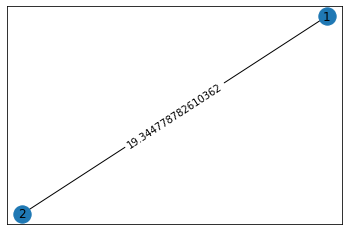

In [27]:
# execute the model and media through the afore-defined function
modelInfo_2 = ["CMM_iAH991V2_iML1515.kb",40576]
mediaInfo_2 = ["Btheta_Ecoli_minimal_media",40576]
communityFBA(modelInfo_2,mediaInfo_2,2100,{"1":0.5,"2":0.5})

## FullThermo-constrained model

### Constrain the model

In [ ]:
# import the model and media
model = kbase.get_from_ws('CMM_iAH991V2_iML1515.kb',40576)
media = kbase.get_from_ws("Btheta_Ecoli_minimal_media",40576)
kmp = KBaseMediaPkg(model)
kmp.build_package(media)

# implement FullThermo with dgbin constraints
modelseed_db_path = '..\..\..\Biofilm growth code\GSWL code\ModelSEEDDatabase'
ftp = fullthermopkg.FullThermoPkg(model)
ftp.build_package({'modelseed_path':modelseed_db_path})

# export the constraint model back to KBase
kbase.save_object('CMM_iAH991V2_iML1515_FullThermo.kb', 'freiburgermsu:narrative_1624557251879', 'KBaseFBA.FBAModel', model) # saving the object back to KBase with id=E_iAH991V2 to the workspace freiburgermsu:narrative_1624557251879 assigning this type KBaseFBA.FBAModel and with data=object_json

# export the constrained LP file 
'''with open('FullThermo.lp', 'w') as out:
    out.write(str(model.solver))'''

### Define and execute the model

In [ ]:
# import the model and media
model = kbase.get_from_ws('CMM_iAH991V2_iML1515.kb',40576)
media = kbase.get_from_ws("Btheta_Ecoli_minimal_media",40576)
kmp = KBaseMediaPkg(model)
kmp.build_package(media)

# establish the CPLEX solver
model.solver = 'optlang-cplex'

# execute the model
model.optimize()
model.summary()

# The 3-member model

## Unconstrained model

### Define and execute the model

In [ ]:
# 3-member community model
model = kbase.get_from_ws('electrosynth_comnty.mdl.gf.2021',93204)
media = kbase.get_from_ws("CO2_minimal",93204)
kmp = KBaseMediaPkg(model)
kmp.build_package(media)

# establish the CPLEX solver
model.solver = 'optlang-cplex'

# execute the model
model.optimize()
model.summary()

## FullThermo-constrained model

### Constrain the model

In [ ]:
from modelseedpy.fbapkg import fullthermopkg

# implement FullThermo with dgbin constraints
modelseed_db_path = '..\..\..\Biofilm growth code\GSWL code\ModelSEEDDatabase'
ftp = fullthermopkg.FullThermoPkg(model)
ftp.build_package({'modelseed_path':modelseed_db_path})

# export the constrained LP file 
'''with open('FullThermo.lp', 'w') as out:
    out.write(str(model.solver))'''

### Define and execute the model

In [ ]:
# 3-member community model
model = kbase.get_from_ws('electrosynth_comnty.mdl.gf.2021',93204)
media = kbase.get_from_ws("CO2_minimal",93204)
kmp = KBaseMediaPkg(model)
kmp.build_package(media)

# establish the CPLEX solver
model.solver = 'optlang-cplex'

# execute the model
model.optimize()
model.summary()

# Brainstorming

In [ ]:
rxn = '123_p0'

if rxn[-1] != '0' and rxn[-1] != 0:
    print(rxn[-1])

In [ ]:
rxn = '123_p1'
compartment_index = rxn.rfind("_")

if (rxn[compartment_index + 1] == 'p' or 'c') and rxn[compartment_index + 2: ] != '0':
    species = rxn[compartment_index + 2:]
    print(species)

In [ ]:
reaction_number = 0
for reaction in model.reactions:
    reaction_number += 1
    
print(reaction_number)